In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
from PIL import Image

In [52]:
# 1. Cargar imagen y convertir a escala de grises
img = Image.open("cebra.jpg").convert("L")  # Asegúrate de tener "input.png" en la carpeta
image_array = np.array(img)


#hacer un padding de 1 pixel a image_array
image_array = np.pad(image_array, (1, 1), mode='constant', constant_values=0)
    
L = 1 #cantidad de imagenes
M, N = image_array.shape
P = 1 #padding
                 
#linealizar image_array
image_array = image_array.reshape(-1)


#exportar en un archivo .txt los valores de la imagen en blanco y negro
with open("imagen2.txt", "w") as archivo:
    archivo.write(f"{L} {M} {N} {P}\n")  # Escribe las dimensiones y el padding
    archivo.write(" ".join(map(str, image_array))) 


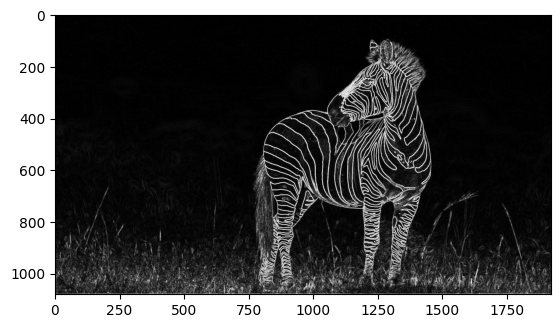

In [74]:
#usar el archivo .txt para cargar la imagen
with open("out_dev_opt.txt", "r") as archivo:
    header = archivo.readline()  # Lee la primera línea con L M N P
    L, M, N = map(int, header.strip().split())
    data = np.fromstring(archivo.read(), sep=" ", dtype=float)

image_array = data.reshape((M, N))

plt.imshow(image_array, cmap='gray')
plt.show()



In [ ]:
# exportar imagen
exported_image = Image.fromarray(image_array.astype(np.uint8))
exported_image.save("output_image.png")


In [15]:
import cv2
import numpy as np

# Parámetros
video_path = "video_sample/boom.mp4"
fps_deseado = 30
padding = 1
L = 0

# Abrir video
cap = cv2.VideoCapture(video_path)
fps_original = cap.get(cv2.CAP_PROP_FPS)
frame_interval = int(round(fps_original / fps_deseado))

M, N = 0, 0
datos_binarios = []

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % frame_interval == 0:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if L == 0:
            M, N = gray.shape

        # Padding
        gray_padded = np.pad(gray, (padding, padding), mode='constant', constant_values=0)

        # Linealizar y guardar como uint8
        datos_binarios.append(gray_padded.astype(np.uint8).reshape(-1))

        L += 1

    frame_count += 1

cap.release()

# Combinar todos los frames
data = np.concatenate(datos_binarios)

# Guardar en archivo binario
data.tofile("video_frames.bin")

# Guardar las dimensiones en archivo de texto
with open("video_frames_dims.txt", "w") as f:
    f.write(f"{L} {M + 2 * padding} {N + 2 * padding} {padding}\n")


In [16]:
import numpy as np
import cv2
import os

# Carpeta donde guardar los videos
output_dir = "videos_resultado"
os.makedirs(output_dir, exist_ok=True)

# Lista de entradas y salidas
archivos = [
    ("video_out_cpu.bin", "video_out_dims_cpu.txt", "video_cpu.avi"),
    ("video_out_gpu.bin", "video_out_dims_gpu.txt", "video_gpu.avi"),
    ("video_out_opt.bin", "video_out_dims_opt.txt", "video_opt.avi")
]

for bin_file, dim_file, video_name in archivos:
    print(f"Procesando {bin_file} → {video_name}")

    # Leer dimensiones
    with open(dim_file, "r") as f:
        L, M, N, _ = map(int, f.readline().split())

    # Leer binario
    data = np.fromfile(bin_file, dtype=np.uint8)

    expected_size = L * M * N
    if data.size != expected_size:
        raise ValueError(f"Archivo {bin_file}: tamaño incorrecto. Esperado {expected_size}, leído {data.size}")

    # Reconstruir frames
    frames = data.reshape((L, M, N))

    # Ruta completa del video de salida
    out_path = os.path.join(output_dir, video_name)

    # Crear objeto para escribir video
    out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'XVID'), 30, (N, M))

    for frame in frames:
        out.write(cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR))  # convertir a 3 canales

    out.release()
    print(f"✓ Video guardado en {out_path}")


Procesando video_out_cpu.bin → video_cpu.avi
✓ Video guardado en videos_resultado\video_cpu.avi
Procesando video_out_gpu.bin → video_gpu.avi
✓ Video guardado en videos_resultado\video_gpu.avi
Procesando video_out_opt.bin → video_opt.avi
✓ Video guardado en videos_resultado\video_opt.avi
